In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from statsmodels.stats.outliers_influence \
import variance_inflation_factor as VIF
from statsmodels.stats.anova import anova_lm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
summarize,
poly)
from sklearn.metrics import accuracy_score
from ISLP import confusion_table
from ISLP.models import contrast

import sklearn.model_selection as skm
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.ensemble import \
    (RandomForestClassifier as RF,
     GradientBoostingClassifier as GBR)
from ISLP.bart import BART

In [3]:
train = pd.read_csv("dataset/train.csv")
test = pd.read_csv("dataset/test.csv")

Fitting Classification Trees

In [12]:
features = ["AI_Interaction_Level", "Satisfaction_with_AI_Services"]

# Selecting only the specified features for X
allvars= train[features]



In [52]:

model = MS(allvars,intercept=False)
D = model.fit_transform(train)
feature_names = list(D.columns)
x_train = np.asarray(D)
churn = np.where(train.Customer_Churn>0,"Yes","No")

In [196]:
clf = DTC(criterion='gini',random_state=0)
clf.fit(x_train,churn)

DecisionTreeClassifier(random_state=0)

In [197]:
model1 = MS(allvars,intercept=False)
D1 = model1.fit_transform(test)

x_test = np.asarray(D1)
test_churn = np.where(test.Customer_Churn>0,"Yes","No")

In [198]:
accuracy_score(test_churn,clf.predict(x_test))

0.6144

In [45]:
ccp_path     =     clf. cost_complexity_pruning_path (x_train ,    churn ) 
kfold     =     skm. KFold (2 ,
random_state =1, 
shuffle =True)

In [46]:
grid     =     skm. GridSearchCV (clf ,
{ 'ccp_alpha':ccp_path.ccp_alphas}, 
refit =True,
cv = kfold ,
scoring ='accuracy')
grid .fit( x_train ,     churn ) 
grid . best_score_

0.5858

[Text(0.5, 0.9285714285714286, 'AI_Interaction_Level <= 2.5\nentropy = 0.981\nsamples = 5000\nvalue = [2909, 2091]'),
 Text(0.2647058823529412, 0.7857142857142857, 'Satisfaction_with_AI_Services <= 3.5\nentropy = 1.0\nsamples = 2570\nvalue = [1285, 1285]'),
 Text(0.14705882352941177, 0.6428571428571429, 'Satisfaction_with_AI_Services <= 2.5\nentropy = 0.998\nsamples = 755\nvalue = [396.0, 359.0]'),
 Text(0.11764705882352941, 0.5, 'AI_Interaction_Level <= 1.5\nentropy = 1.0\nsamples = 483\nvalue = [243.0, 240.0]'),
 Text(0.058823529411764705, 0.35714285714285715, 'Satisfaction_with_AI_Services <= 1.5\nentropy = 0.998\nsamples = 167\nvalue = [79.0, 88.0]'),
 Text(0.029411764705882353, 0.21428571428571427, 'entropy = 0.998\nsamples = 82\nvalue = [43, 39]'),
 Text(0.08823529411764706, 0.21428571428571427, 'entropy = 0.983\nsamples = 85\nvalue = [36.0, 49.0]'),
 Text(0.17647058823529413, 0.35714285714285715, 'Satisfaction_with_AI_Services <= 1.5\nentropy = 0.999\nsamples = 316\nvalue = [164

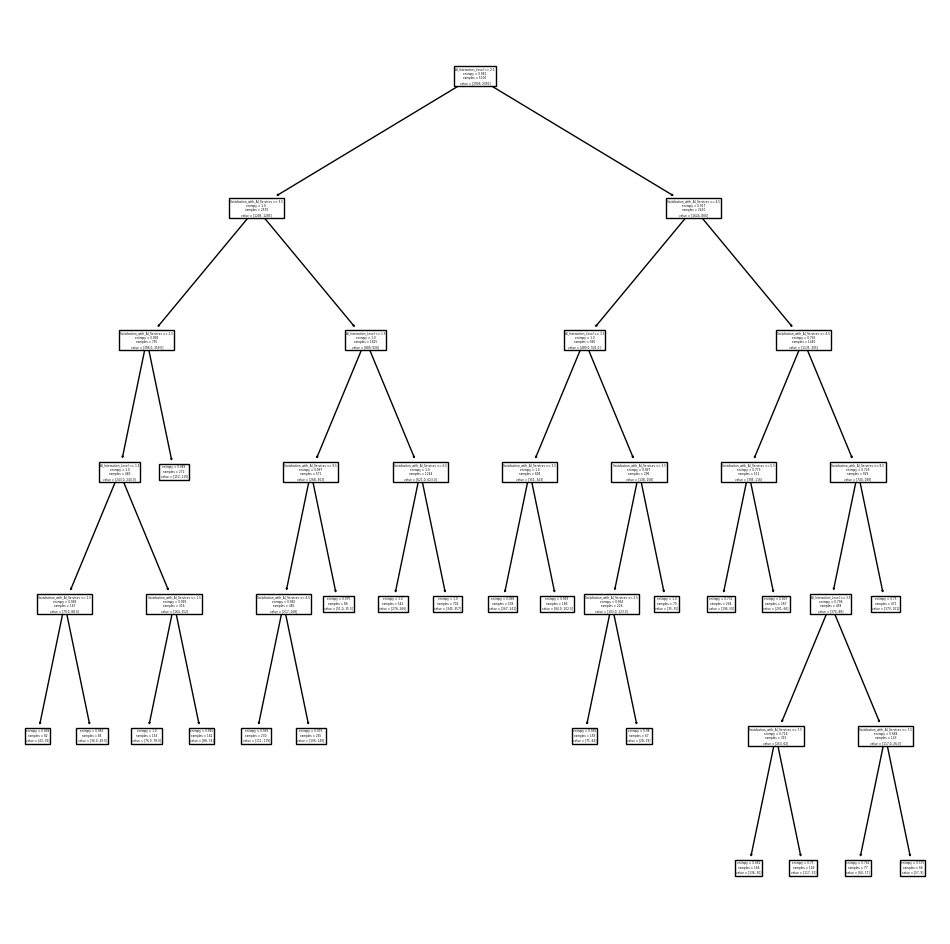

In [47]:
ax     =     subplots ( figsize =(12 ,     12) ) [1] 
best_     =     grid . best_estimator_
plot_tree (best_ ,
feature_names =feature_names , 
ax = ax )

In [48]:
print ( accuracy_score ( test_churn ,
best_ . predict ( x_test )))
confusion = confusion_table (best_. predict ( x_test),
test_churn )
confusion

0.6016


Truth,No,Yes
Predicted,,
No,490,274
Yes,224,262


In [67]:
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Assuming ccp_path and alphas are already obtained as before
alphas = ccp_path.ccp_alphas

# Initialize KFold
kfold = KFold(20, random_state=1, shuffle=True)

# To store the average accuracy for each alpha
avg_accuracy_scores = []

for alpha in alphas:
    # List to store accuracy scores for each fold
    accuracy_scores = []
    
    # K-Fold Cross Validation
    for train_index, test_index in kfold.split(x_train):
        # Use direct indexing for NumPy arrays
        X_train_folds, X_test_folds = x_train[train_index], x_train[test_index]
        y_train_folds, y_test_folds = churn[train_index], churn[test_index]
        
        # Create and fit the model for the current alpha
        clf_alpha = DecisionTreeClassifier(random_state=0, ccp_alpha=alpha)
        clf_alpha.fit(X_train_folds, y_train_folds)
        
        # Make predictions and calculate accuracy for the current fold
        predictions = clf_alpha.predict(X_test_folds)
        accuracy_scores.append(accuracy_score(y_test_folds, predictions))
    
    # Calculate the average accuracy across all folds for the current alpha
    avg_accuracy_scores.append(np.mean(accuracy_scores))

# Find the alpha with the highest average accuracy score
optimal_alpha = alphas[np.argmax(avg_accuracy_scores)]
print(f"Optimal alpha for cost complexity pruning: {optimal_alpha}")


Optimal alpha for cost complexity pruning: 0.027045085740772412


bagging and random forests

In [68]:
y_train =train["Customer_Churn"]
y_test = test["Customer_Churn"]

In [86]:
x_train_all = MS(train.columns.drop(["ID","Customer_Churn"]),intercept=False).fit_transform(train)
x_test_all = MS(test.columns.drop(["ID","Customer_Churn"]),intercept=False).fit_transform(test)

In [87]:
bag_data = RF(max_features=x_train_all.shape[1],random_state=0)
bag_data.fit(x_train_all,y_train)

RandomForestClassifier(max_features=8, random_state=0)

0.3584

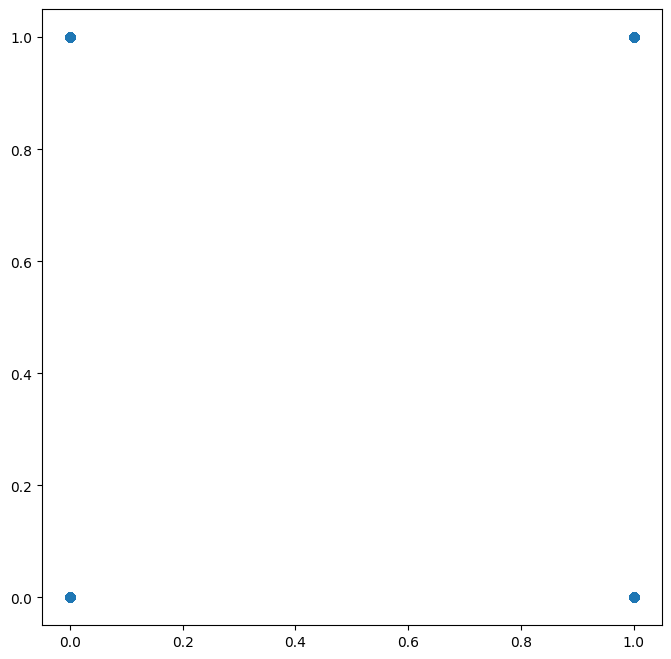

In [88]:
ax     =     subplots ( figsize =(8 ,8) ) [1]
y_hat_bag     =     bag_data . predict ( x_test_all) 
ax . scatter ( y_hat_bag ,     y_test )
np . mean (( y_test     -     y_hat_bag ) **2)

In [89]:
bag_boston     =    RF( max_features = x_train_all .shape [1],
n_estimators =500 ,
random_state =0).fit(x_train_all ,     y_train )
y_hat_bag     =     bag_boston . predict ( x_test_all) 
np . mean (( y_test     -     y_hat_bag ) **2)

0.356

In [90]:
RF_data     =    RF( max_features =6,
random_state =0).fit(x_train_all ,     y_train )
y_hat_RF     =     RF_data . predict ( x_test_all ) 
np . mean (( y_test     -     y_hat_RF ) **2)

0.3496

In [91]:
feature_names = list(x_train_all.columns)
feature_imp     =    pd. DataFrame (
{ 'importance':RF_data.feature_importances_}, 
index = feature_names )
feature_imp . sort_values (by='importance',ascending=False)

,importance
Overall_Usage_Frequency,0.213057
Age,0.207655
Customer_Service_Interactions,0.143236
Satisfaction_with_AI_Services,0.119749
AI_Personalization_Effectiveness,0.099496
Change_in_Usage_Patterns,0.093138
AI_Interaction_Level,0.063792
AI_Response_Time,0.059878


boosting

In [190]:
boost_data     =    GBR( n_estimators =10000 ,
learning_rate =0.015 , 
max_depth =3,
random_state =0)
boost_data .fit(x_train ,     y_train )

GradientBoostingClassifier(learning_rate=0.015, n_estimators=10000,
                           random_state=0)

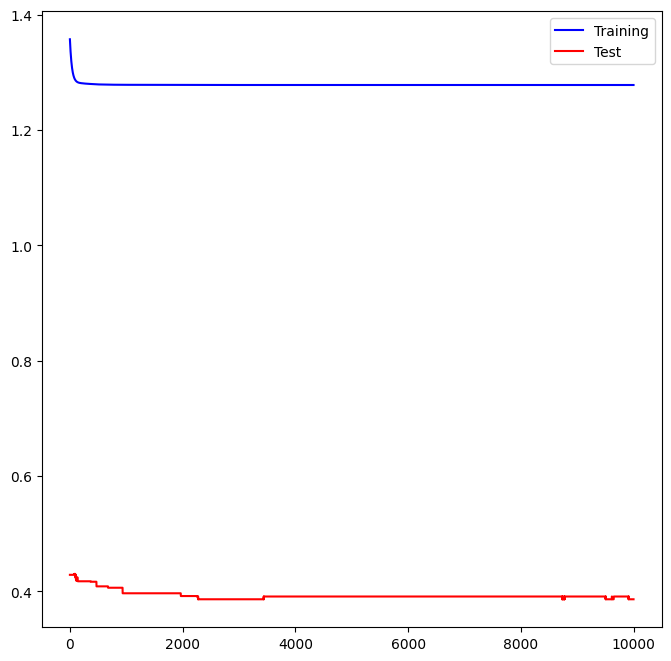

In [192]:
test_error     =    np. zeros_like ( boost_data . train_score_ )
for     idx ,     y_     in     enumerate ( boost_data . staged_predict ( x_test )): 
    test_error [idx]    =    np.mean (( y_test     -    y_)**2)
plot_idx     =    np. arange ( boost_data . train_score_ .shape [0]) 
ax     =     subplots ( figsize =(8 ,8) ) [1]
ax . plot ( plot_idx ,
boost_data .train_score_ , 
'b',
label ='Training')
ax . plot ( plot_idx ,
test_error , 
'r',
label ='Test')
ax . legend () 

In [193]:
y_hat_boost     =     boost_data . predict (x_test)
np . mean (( y_test     -     y_hat_boost ) **2)

0.3864

In [194]:
# Assuming 'original_test_data' is your original DataFrame with IDs
test_ids = test['ID']
predictions_df = pd.DataFrame({
    'ID': test_ids,
    'Prediction': y_hat_boost
})
predictions_df.to_csv('predictions.csv', index=False)

In [195]:
merged_df = pd.merge(test[["ID","Customer_Churn"]], predictions_df, on='ID')
# Assuming the actual outcomes are in a column named 'Actual_Outcome'
# Count how many predictions match the actual outcomes
correct_predictions = (merged_df['Customer_Churn'] == merged_df['Prediction']).sum()

print(f"Number of correct predictions: {correct_predictions}")
print(f"Total predictions made: {len(merged_df)}")
accuracy = correct_predictions / len(merged_df)
print(f"Accuracy: {accuracy:.2%}")


Number of correct predictions: 767
Total predictions made: 1250
Accuracy: 61.36%
